In [41]:
from skimage.io import imread
from deepcell.applications import Mesmer
import numpy as np
import os
import glob 
from PIL import Image
from skimage.util import img_as_uint
from skimage.io import imread,imsave,imshow
from skimage import img_as_ubyte
import anndata as ad
import numpy as np
import tifffile
from ome_types import from_tiff, from_xml, to_xml, model
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/data/twang15/spatial_protein/code/TiffComponents.py')
import TiffComponents

In [3]:
# 加载模型
os.environ.update({"DEEPCELL_ACCESS_TOKEN": "NsIDJwZP.CPA75NbJ5jQG6zPF7FPYlOBYdf1IHeqW"})
app = Mesmer()

Checking for cached data
Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
Extracting /home/twang15/.deepcell/models/MultiplexSegmentation-9.tar.gz
Successfully extracted /home/twang15/.deepcell/models/MultiplexSegmentation-9.tar.gz into /home/twang15/.deepcell/models


2024-05-01 10:38:36.634992: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 10:38:37.825505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30554 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-05-01 10:38:37.826306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30997 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [4]:
channel_mapping = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45RO'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)'],
    'ER': ['ER', 'ER-(D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1a': ['HIF1a', 'HIF1a (D)'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
}
r_channel_mapping = {v:k for k, vs in channel_mapping.items() for v in vs}
nuclei = ['DAPI']
membrane = ['Pan-Cytokeratin', 'CD45', 'CD8', 'CD3e', 'Vimentin', 'SMA', 'CD31', 'CD20']

In [5]:
channel_names = []
channel_file = '/data/twang15/spatial_protein/CODEX_data_26/hpapdata/HPAP-007/CODEX_Staining/channelName.txt'
with open(channel_file, 'r') as file:
    for line in file:
        channel_names.append(line.strip())

In [5]:
channel_names

['DAPI',
 'GCG',
 'CD45',
 'CD19',
 'ECAD',
 'COL1A1',
 'LAM',
 'SST',
 'KRT',
 'DPP4',
 'ACTA2',
 'CPEP',
 'CD3',
 'CD31',
 'GHRL',
 'CD11c',
 'LYVE1',
 'MCAM',
 'IBA1',
 'CD117',
 'proINS',
 'COL4A1',
 'PNLIP',
 'PPY',
 'SYP']

In [6]:
nuclei_channel = [marker for marker in nuclei if marker in nuclei]
membrane_channel = [marker for marker in membrane if marker in membrane]

In [7]:
def merge_channels(channel_to_img, channels, thresh=.01, contrast_pct=95.):
    img = None
    for c in channels:
        if c not in channel_to_img:
            print(f'warning: {c} not in image')
            pass
        else:
            X = channel_to_img[c].copy().astype(np.float32)
            X -= X.min()
            X /= X.max()
            vmax = np.percentile(X[X>0], (contrast_pct)) if np.count_nonzero(X) else 1.
            X = rescale_intensity(X, in_range=(0., vmax))

            X = np.expand_dims(X, 0)

            if img is None:
                img = X
            else:
                img = np.concatenate((img, X), axis=0)

    img = np.mean(img, axis=0)
    return img

In [8]:
img_channels, imgs, imgs_dict = TiffComponents.extract_ometiff('/data/twang15/spatial_protein/CODEX_data_26/hpapdata/HPAP-007/CODEX_Staining/output.ome.tiff')

In [17]:
imgs.shape

(25, 25200, 13440)

In [27]:
nuclei_img = merge_channels(imgs_dict, nuclei_channel)
membrane_img = merge_channels(imgs_dict, membrane_channel)

In [28]:
input_img = np.concatenate((np.expand_dims(nuclei_img, axis=-1),
                            np.expand_dims(membrane_img, axis=-1)),
                           axis=-1)
input_img = np.expand_dims(input_img, axis=0)

In [25]:
membrane_img.shape

(1, 25200, 13440, 1)

In [30]:
labeled_membrane_image_mesmer = app.predict(input_img, image_mpp=0.325, compartment='both')

/data/twang15/mamba/envs/trans/lib/python3.8/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


In [32]:
labeled_membrane_image_mesmer.shape

(1, 25200, 13440, 2)

In [33]:
cell_labels = labeled_membrane_image_mesmer[0, ..., 0]
nuclei_labels = labeled_membrane_image_mesmer[0, ..., 1]

In [36]:
Image.fromarray(cell_labels).save(f'/data/twang15/spatial_protein/CODEX_data_26/hpapdata/HPAP-007/CODEX_Staining/img_output/cell_labels.tiff')
Image.fromarray(nuclei_labels).save(f'/data/twang15/spatial_protein/CODEX_data_26/hpapdata/HPAP-007/CODEX_Staining/img_output/nuclei_labels.tiff')

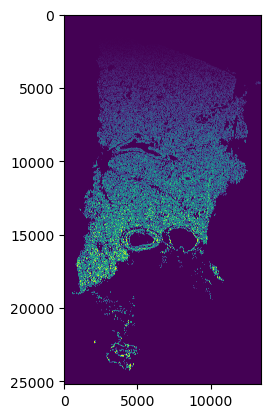

In [43]:
plt.imshow(cell_labels)
plt.imshow(nuclei_labels)

In [44]:
from glob import glob
from itertools import compress
import numpy as np
import os
import pandas as pd
from PIL import Image
from skimage.io import imread,imshow,imsave 
from skimage.measure import regionprops_table
import time
import warnings
warnings.filterwarnings(action='ignore')
Image.MAX_IMAGE_PIXELS = None

In [45]:
mask_marker_list = nuclei_channel + membrane_channel

In [48]:
s = regionprops_table(cell_labels, intensity_image=cell_labels, properties=('label','mean_intensity','area','centroid','eccentricity','axis_major_length','axis_minor_length'))
df = pd.DataFrame(s)
cell_id = df['mean_intensity']
area = df['area']
centroid_X = df['centroid-1'] 
centroid_Y = df['centroid-0']
eccentricity = df['eccentricity']
axis_major_length = df['axis_major_length']
axis_minor_length = df['axis_minor_length']

df = pd.concat([cell_id, area, centroid_X, centroid_Y, eccentricity, axis_major_length, axis_minor_length], axis=1, join='outer')
df.rename(columns={'mean_intensity':'cell_id'}, inplace=True)
df.rename(columns={'centroid-1':'centroid_X'}, inplace=True)
df.rename(columns={'centroid-0':'centroid_Y'}, inplace=True)
    

In [49]:
df

,cell_id,area,centroid_X,centroid_Y,eccentricity,axis_major_length,axis_minor_length
0,1.0,5202,3023.130719,16.664937,0.984716,207.846547,36.199847
1,2.0,5067,3309.617328,15.147622,0.983253,197.837810,36.054625
2,3.0,4999,3613.830366,14.256851,0.986694,211.544426,34.395064
3,4.0,5292,3916.442933,12.772676,0.989417,229.863366,33.353933
4,5.0,4789,4208.406348,11.863855,0.989873,226.812456,32.196676
...,...,...,...,...,...,...,...
223038,223039.0,660,4467.213636,24218.550000,0.703794,35.746776,25.394659
223039,223040.0,5158,4179.112641,24262.403257,0.881104,127.707831,60.395990
223040,223041.0,987,4453.724417,24251.746707,0.867575,51.659720,25.690747
223041,223042.0,258,4473.232558,24247.527132,0.952150,33.853411,10.346688


In [53]:
markers = [marker for marker in channel_names if marker not in nuclei_channel]
from tqdm import tqdm

for marker in tqdm(markers):
    table = regionprops_table(cell_labels, intensity_image=imgs_dict[marker], properties=('label','mean_intensity','centroid'))
    df_table = pd.DataFrame(table)
    df_total = pd.concat([df,df_table],axis=1,join='outer')
    df_total.rename(columns={'mean_intensity': marker},inplace=True)
    df = df_total

In [54]:
df.to_csv('/data/twang15/spatial_protein/CODEX_data_26/hpapdata/HPAP-007/CODEX_Staining/img_output/cell_df.txt', sep='\t')

In [55]:
df

,cell_id,area,centroid_X,centroid_Y,eccentricity,axis_major_length,axis_minor_length,label,GCG,centroid-0,...,centroid-0,centroid-1,label,PPY,centroid-0,centroid-1,label,SYP,centroid-0,centroid-1
0,1.0,5202,3023.130719,16.664937,0.984716,207.846547,36.199847,1,2.645329,16.664937,...,16.664937,3023.130719,1,2.484429,16.664937,3023.130719,1,2.602268,16.664937,3023.130719
1,2.0,5067,3309.617328,15.147622,0.983253,197.837810,36.054625,2,2.412078,15.147622,...,15.147622,3309.617328,2,2.297612,15.147622,3309.617328,2,2.379515,15.147622,3309.617328
2,3.0,4999,3613.830366,14.256851,0.986694,211.544426,34.395064,3,2.446289,14.256851,...,14.256851,3613.830366,3,2.358472,14.256851,3613.830366,3,2.410282,14.256851,3613.830366
3,4.0,5292,3916.442933,12.772676,0.989417,229.863366,33.353933,4,2.101663,12.772676,...,12.772676,3916.442933,4,2.054422,12.772676,3916.442933,4,2.120370,12.772676,3916.442933
4,5.0,4789,4208.406348,11.863855,0.989873,226.812456,32.196676,5,1.854249,11.863855,...,11.863855,4208.406348,5,1.821883,11.863855,4208.406348,5,1.938818,11.863855,4208.406348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223038,223039.0,660,4467.213636,24218.550000,0.703794,35.746776,25.394659,223039,2.215152,24218.550000,...,24218.550000,4467.213636,223039,1.195455,24218.550000,4467.213636,223039,3.931818,24218.550000,4467.213636
223039,223040.0,5158,4179.112641,24262.403257,0.881104,127.707831,60.395990,223040,2.208802,24262.403257,...,24262.403257,4179.112641,223040,2.213455,24262.403257,4179.112641,223040,2.312718,24262.403257,4179.112641
223040,223041.0,987,4453.724417,24251.746707,0.867575,51.659720,25.690747,223041,2.124620,24251.746707,...,24251.746707,4453.724417,223041,1.358663,24251.746707,4453.724417,223041,3.017224,24251.746707,4453.724417
223041,223042.0,258,4473.232558,24247.527132,0.952150,33.853411,10.346688,223042,2.337209,24247.527132,...,24247.527132,4473.232558,223042,2.178295,24247.527132,4473.232558,223042,3.100775,24247.527132,4473.232558


In [56]:
s = regionprops_table(nuclei_labels, intensity_image=nuclei_labels, 
           properties=('label','mean_intensity','area','centroid','eccentricity' ))

df_nu = pd.DataFrame(s)
cell_id = df_nu['mean_intensity']
area = df_nu['area']
centroid_X = df_nu['centroid-1']
centroid_Y = df_nu['centroid-0']
eccentricity = df_nu['eccentricity']

df_nu = pd.concat([cell_id, area, centroid_X, centroid_Y, eccentricity], axis=1, join='outer')
df_nu.rename(columns={'mean_intensity':'cell_id'}, inplace=True)
df_nu.rename(columns={'centroid-1':'centroid_X'}, inplace=True)
df_nu.rename(columns={'centroid-0':'centroid_Y'}, inplace=True)
df_nu.rename(columns={'area':'area_nuc'}, inplace=True)

In [57]:
df_nu

,cell_id,area_nuc,centroid_X,centroid_Y,eccentricity
0,1.0,1161,2508.739879,451.242894,0.888630
1,2.0,85,2557.788235,473.788235,0.607897
2,3.0,792,2532.683081,476.358586,0.869721
3,4.0,1360,2577.097794,509.781618,0.894086
4,5.0,213,2562.582160,541.065728,0.413616
...,...,...,...,...,...
225675,225676.0,615,4467.099187,24219.474797,0.768795
225676,225677.0,337,4157.747774,24240.934718,0.761349
225677,225678.0,821,4455.006090,24252.717418,0.871848
225678,225679.0,2508,4415.169458,24295.838517,0.445950


In [58]:
col1 = channel_names
col2 = ['cell_id', 'area', 'centroid_X','centroid_Y', 'eccentricity','axis_major_length','axis_minor_length']
col = col2 + channel_names
col

['cell_id',
 'area',
 'centroid_X',
 'centroid_Y',
 'eccentricity',
 'axis_major_length',
 'axis_minor_length',
 'DAPI',
 'GCG',
 'CD45',
 'CD19',
 'ECAD',
 'COL1A1',
 'LAM',
 'SST',
 'KRT',
 'DPP4',
 'ACTA2',
 'CPEP',
 'CD3',
 'CD31',
 'GHRL',
 'CD11c',
 'LYVE1',
 'MCAM',
 'IBA1',
 'CD117',
 'proINS',
 'COL4A1',
 'PNLIP',
 'PPY',
 'SYP']

In [65]:
col1 = [marker for marker in channel_names if marker != 'DAPI']
col2 = ['cell_id', 'area', 'centroid_X','centroid_Y', 'eccentricity','axis_major_length','axis_minor_length']
col = col2 + col1
cell_final = df[col]

total = pd.merge(cell_final, df_nu, on=['cell_id'], how='inner')
total.rename(columns={'centroid_X_x':'centroid_X'}, inplace=True)
total.rename(columns={'centroid_Y_x':'centroid_Y'}, inplace=True)
total = total.drop(columns = ['centroid_X_y','centroid_Y_y'])
total.rename(columns={'eccentricity_x':'eccentricity_cell'}, inplace=True)
total.rename(columns={'eccentricity_y':'eccentricity_nuc'}, inplace=True)
total.to_csv(f'/data/twang15/spatial_protein/CODEX_data_26/hpapdata/HPAP-007/CODEX_Staining/img_output/HPAP-007_expression.csv')


In [63]:
total

,cell_id,area,centroid_X_x,centroid_Y_x,eccentricity_x,axis_major_length,axis_minor_length,GCG,CD45,CD19,...,CD117,proINS,COL4A1,PNLIP,PPY,SYP,area_nuc,centroid_X_y,centroid_Y_y,eccentricity_y
0,1.0,5202,3023.130719,16.664937,0.984716,207.846547,36.199847,2.645329,0.296617,0.0,...,0.000000,0.016724,0.000000,0.000000,2.484429,2.602268,1161,2508.739879,451.242894,0.888630
1,2.0,5067,3309.617328,15.147622,0.983253,197.837810,36.054625,2.412078,0.272745,0.0,...,0.000000,0.016578,0.000000,0.000000,2.297612,2.379515,85,2557.788235,473.788235,0.607897
2,3.0,4999,3613.830366,14.256851,0.986694,211.544426,34.395064,2.446289,0.273455,0.0,...,0.000000,0.019404,0.000000,0.002400,2.358472,2.410282,792,2532.683081,476.358586,0.869721
3,4.0,5292,3916.442933,12.772676,0.989417,229.863366,33.353933,2.101663,0.433107,0.0,...,0.000000,0.017385,0.000000,0.000000,2.054422,2.120370,1360,2577.097794,509.781618,0.894086
4,5.0,4789,4208.406348,11.863855,0.989873,226.812456,32.196676,1.854249,0.368971,0.0,...,0.000000,0.011485,0.000000,0.000418,1.821883,1.938818,213,2562.582160,541.065728,0.413616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223038,223039.0,660,4467.213636,24218.550000,0.703794,35.746776,25.394659,2.215152,3.689394,0.0,...,0.000000,0.000000,33.783333,0.478788,1.195455,3.931818,215,1947.386047,18199.418605,0.457309
223039,223040.0,5158,4179.112641,24262.403257,0.881104,127.707831,60.395990,2.208802,1.715006,0.0,...,0.002908,0.010081,3.091702,0.133191,2.213455,2.312718,273,1966.142857,18198.205128,0.856316
223040,223041.0,987,4453.724417,24251.746707,0.867575,51.659720,25.690747,2.124620,0.891591,0.0,...,0.000000,0.001013,27.168186,0.469098,1.358663,3.017224,353,2296.770538,18199.657224,0.666469
223041,223042.0,258,4473.232558,24247.527132,0.952150,33.853411,10.346688,2.337209,3.740310,0.0,...,0.000000,1.643411,10.162791,1.178295,2.178295,3.100775,202,3034.207921,18199.500000,0.194782


In [68]:
x = total.loc[:, col1]
obs = total.loc[:, [colname for colname in total.columns.tolist() if colname not in col1]]

In [73]:
adata = ad.AnnData(X=x, obs=obs)

In [74]:
adata

AnnData object with n_obs × n_vars = 223043 × 24
    obs: 'cell_id', 'area', 'centroid_X', 'centroid_Y', 'eccentricity_cell', 'axis_major_length', 'axis_minor_length', 'area_nuc', 'eccentricity_nuc'

In [75]:
adata.write_h5ad('/data/twang15/spatial_protein/CODEX_data_26/hpapdata/HPAP-007/CODEX_Staining/img_output/HPAP-007.h5ad')